# Fit QCD background, stage 2.

Stage 1 must have already been run. This notebook runs on python3, requires some up-to-date(ish) - i.e. not in the analysis environment.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as spo
import scipy.integrate as spi

In [2]:
df = pd.read_csv("dataset.csv")
df["BkgErr"].replace(0,0.00001,inplace=True)
df = df[1:]

inv01df = df[df["binCentre"] < 0.1]
inv04df = df[df["binCentre"] < 0.4]
SRdf = df[df["binCentre"] > 0.4]

print(df.head(10))

    Unnamed: 0         Bkg     BkgErr    Data     DataErr  binCentre  \
1            1  939.841615  26.451793  4161.0  119.213886       0.01   
2            2  933.687436  29.685794  3900.0  115.758100       0.03   
3            3  919.362968  26.892316  3564.0  109.648342       0.05   
4            4  900.414704  27.381989  3214.0  104.111351       0.07   
5            5  883.781471  26.133448  2912.0   99.602516       0.09   
6            6  879.350587  29.085468  2420.0   90.518005       0.11   
7            7  834.912091  24.861752  2033.0   83.138215       0.13   
8            8  818.391582  24.907261  1824.0   78.917988       0.15   
9            9  799.615120  27.535733  1550.0   72.103524       0.17   
10          10  780.550607  25.896218  1354.0   67.071730       0.19   

          diJet    diJetErr         Diff     DiffErr  
1   4420.857258  177.325485  3221.158385  122.113259  
2   4061.832487  185.397418  2966.312564  119.503908  
3   3677.295255  170.265291  2644.637032  

In [3]:
INT_QCD_RCR = sum(inv01df["Diff"])
INT_QCD_RCR = 13173.912
INT_MC_R = sum(SRdf["diJet"])
print(INT_QCD_RCR, INT_MC_R)


13173.912 968.6878763854319


In [4]:
## Define all possible fit functions
# Two var distributions
def exp_distrib(x, a, b):
    return a*np.exp(b*x)

def exp_quadratic(x, a, b):
    return a*np.exp(-b*x*x)

# Three var distributions
def exp_quadratic_threeterm (x, a, b, c):
    return a*np.exp(-b*x*x+c*x)

def exp_powerlaw(x, a, b, c):
    return a*np.exp(-b*(x**c))

def lorentz(x, gamma, x0, A):
    return A/(np.pi*gamma*(1+((x-x0)/gamma)*((x-x0)/gamma)))

def exp_addition(x, a, b, c, d):
    return a*np.exp(-b*x*x)+c*np.exp(d*x)

def gradfexpa(x, a, b, c, d):
    return np.array([np.exp(-b*x*x), -a*x*x*np.exp(-b*x*x), np.exp(d*x), c*x*np.exp(d*x)])

def exp_addition_err2(x, a, b, c, d, cov):
    # TODO this is a very ugly implementtation but vectorising all the matrix products correctly
    # Is a a massive pain.
    grada = np.exp(-b*x*x)
    gradb = -a*x*x*np.exp(-b*x*x)
    gradc = np.exp(d*x)
    gradd = c*x*np.exp(d*x)
    return np.sqrt((cov[0][0]*grada+cov[0][1]*gradb+cov[0][2]*gradc+cov[0][3]*gradd)*grada + 
                    (cov[1][0]*grada+cov[1][1]*gradb+cov[1][2]*gradc+cov[1][3]*gradd)*gradb +
                    (cov[2][0]*grada+cov[2][1]*gradb+cov[2][2]*gradc+cov[2][3]*gradd)*gradc +
                    (cov[3][0]*grada+cov[3][1]*gradb+cov[3][2]*gradc+cov[3][3]*gradd)*gradd)

def rat(x, a, b):
    return a*((1+x**b)**(-b))

In [5]:
params_exp, cov = spo.curve_fit(exp_distrib, df["binCentre"], df["Bkg"])
params_expq, cov = spo.curve_fit(exp_quadratic, df["binCentre"].values, df["Bkg"].values)
params_expqt, cov = spo.curve_fit(exp_quadratic_threeterm, df["binCentre"], df["Bkg"])
params_exppl, cov = spo.curve_fit(exp_powerlaw, df["binCentre"], df["Bkg"])
params_expa, cov_expa = spo.curve_fit(exp_addition, df["binCentre"], df["Bkg"], p0=[1500, 50, 1500, -9])
#params_expa, cov_expa = spo.curve_fit(exp_addition, df["binCentre"], df["Bkg"], p0=[1500, 50, 1500, -9])
params_lorentz, cov = spo.curve_fit(lorentz, df["binCentre"], df["Bkg"])
params_rat, cov = spo.curve_fit(rat, df["binCentre"], df["Bkg"], bounds=([3, 2.0000001], [np.inf, np.inf]),  p0=[3000, 20])


/home/ppe/t/tprocter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/usr/local/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[1094.28760024   -2.15596779] [868.6282816   2.9097214] [580.39517146   3.99160756 363.49848382  -1.46872949]
[[ 7.95483553e+01 -6.22448809e-03 -9.60082289e+01  1.95225662e-01]
 [-6.22448809e-03  1.09551536e-03  3.46492568e-02  1.52931313e-04]
 [-9.60082289e+01  3.46492568e-02  1.19556237e+02 -2.43616090e-01]
 [ 1.95225662e-01  1.52931313e-04 -2.43616090e-01  6.03222462e-04]]


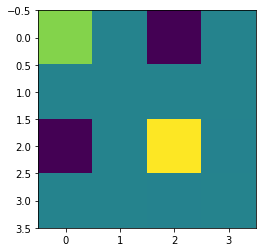

In [6]:
print(params_exp, params_expq, params_expa)
print(cov_expa)
plt.imshow(cov_expa)

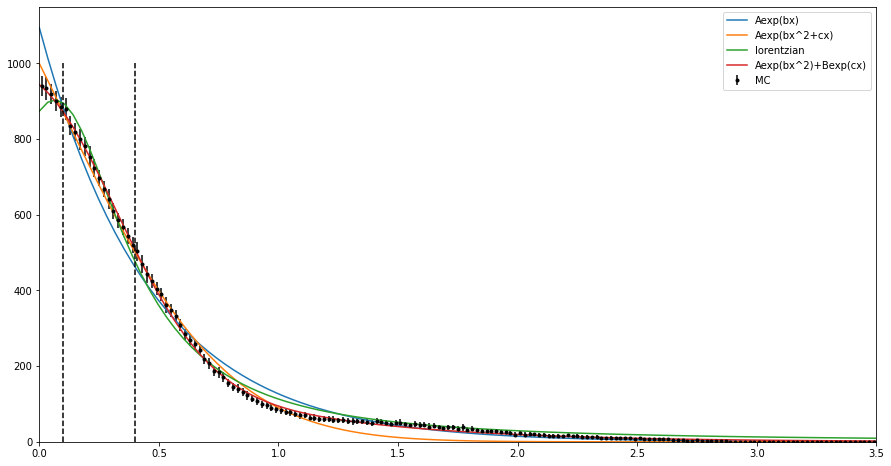

In [7]:
fig,ax = plt.subplots(1,1,figsize=[15,8])
ax.errorbar(df["binCentre"], df["Bkg"], label="MC", yerr=df["BkgErr"], fmt=".", color="k")
#ax.plot(df["binCentre"], df["Diff"], "g.", label="DD")
ax.plot(np.linspace(0, 3.5, 100), exp_distrib(np.linspace(0, 3.5, 100), params_exp[0], params_exp[1]), label="Aexp(bx)")
#ax.plot(np.linspace(0, 3.5, 100), exp_quadratic(np.linspace(0, 3.5, 100), params_expq[0], params_expq[1]), label="Aexp(bx^2)")
ax.plot(np.linspace(0, 3.5, 100), exp_quadratic_threeterm(np.linspace(0, 3.5, 100), params_expqt[0], params_expqt[1], params_expqt[2]), label="Aexp(bx^2+cx)")
ax.plot(np.linspace(0, 3.5, 100), lorentz(np.linspace(0, 3.5, 100), params_lorentz[0], params_lorentz[1], params_lorentz[2]), label="lorentzian")
ax.plot(np.linspace(0, 3.5, 100), exp_addition(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3]), label="Aexp(bx^2)+Bexp(cx)")
#ax.plot(np.linspace(0, 3.5, 100), rat(np.linspace(0, 3.5, 100), params_rat[0], params_rat[1]), label="rat")

ax.plot([0.4,0.4],[0,1000],"k--")
ax.plot([0.1,0.1],[0,1000],"k--")

ax.set_ylim(0, None)
ax.set_xlim(0, 3.5)
ax.legend()
fig.show()

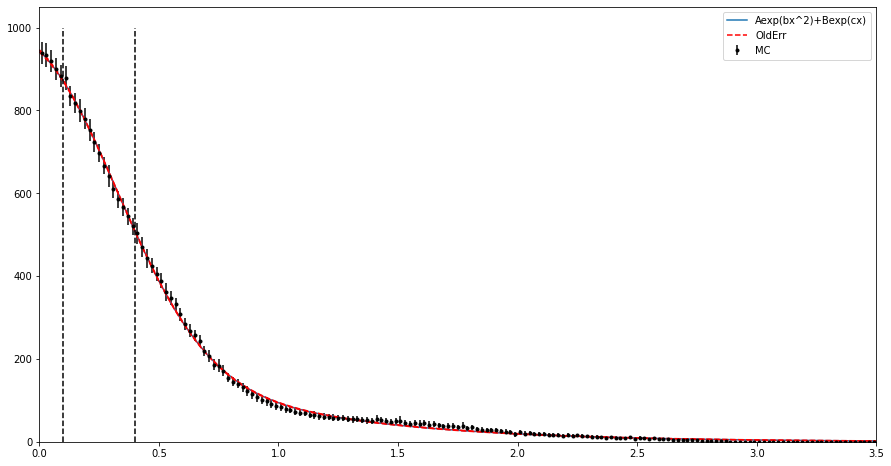

In [8]:
fig,ax = plt.subplots(1,1,figsize=[15,8])
ax.errorbar(df["binCentre"], df["Bkg"], label="MC", yerr=df["BkgErr"], fmt=".", color="k")
#ax.plot(df["binCentre"], df["Diff"], "g.", label="DD")
ax.plot(np.linspace(0, 3.5, 100), exp_addition(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3]), label="Aexp(bx^2)+Bexp(cx)")
ax.plot(np.linspace(0, 3.5, 100), exp_addition(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3])+exp_addition_err2(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--", label="OldErr")
ax.plot(np.linspace(0, 3.5, 100), exp_addition(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3])-exp_addition_err2(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--")
#ax.plot(np.linspace(0, 3.5, 100), exp_addition(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3])-exp_addition_error(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--", label="Err")
#ax.plot(np.linspace(0, 3.5, 100), rat(np.linspace(0, 3.5, 100), params_rat[0], params_rat[1]), label="rat")

ax.plot([0.4,0.4],[0,1000],"k--")
ax.plot([0.1,0.1],[0,1000],"k--")

ax.set_ylim(0, None)
ax.set_xlim(0, 3.5)
ax.legend()
fig.show()

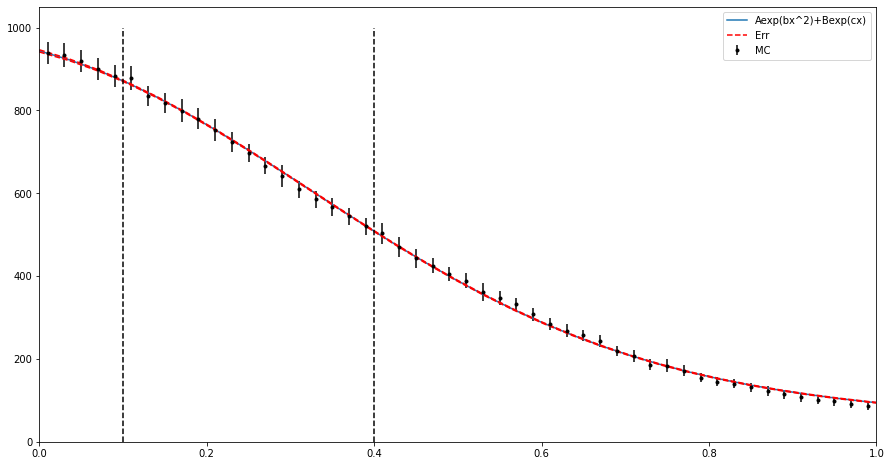

In [9]:
fig,ax = plt.subplots(1,1,figsize=[15,8])
ax.errorbar(df["binCentre"], df["Bkg"], label="MC", yerr=df["BkgErr"], fmt=".", color="k")
#ax.plot(df["binCentre"], df["Diff"], "g.", label="DD")
ax.plot(np.linspace(0, 3.5, 100), exp_addition(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3]), label="Aexp(bx^2)+Bexp(cx)")
ax.plot(np.linspace(0, 3.5, 100), exp_addition(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3])+exp_addition_err2(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--", label="Err")
ax.plot(np.linspace(0, 3.5, 100), exp_addition(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3])-exp_addition_err2(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--")

#ax.plot(np.linspace(0, 3.5, 100), rat(np.linspace(0, 3.5, 100), params_rat[0], params_rat[1]), label="rat")

ax.plot([0.4,0.4],[0,1000],"k--")
ax.plot([0.1,0.1],[0,1000],"k--")

ax.set_ylim(0, None)
ax.set_xlim(0, 1.0)
ax.legend()
fig.show()

In [10]:
params_exp, cov_exp = spo.curve_fit(exp_distrib, inv04df["binCentre"], inv04df["Diff"])
params_expq, cov_expq = spo.curve_fit(exp_quadratic, inv04df["binCentre"].values, inv04df["Diff"].values)
params_expqt, cov_expqt = spo.curve_fit(exp_quadratic_threeterm, inv04df["binCentre"], inv04df["Diff"])
params_exppl, cov_exppl = spo.curve_fit(exp_powerlaw, inv04df["binCentre"], inv04df["Diff"])
params_expa, cov_expa = spo.curve_fit(exp_addition, inv04df["binCentre"], inv04df["Diff"], sigma=inv04df["DiffErr"])
#params_expa, cov_expa = spo.curve_fit(exp_addition, inv04df["binCentre"], inv04df["Diff"])
params_lorentz, cov_lorentz = spo.curve_fit(lorentz, inv04df["binCentre"], inv04df["Diff"])
params_rat, cov_rat = spo.curve_fit(rat, inv04df["binCentre"], inv04df["Diff"], bounds=([3, 2.0000001], [np.inf, np.inf]),  p0=[3000, 20])

def exp_final(x):
    return exp_distrib(x, params_exp[0], params_exp[1])

def expqt_final(x):
    return exp_quadratic_threeterm(x, params_expqt[0], params_expqt[1], params_expqt[2])

def lorentz_final(x):
    return lorentz(x, params_lorentz[0], params_lorentz[1], params_lorentz[2])

def expa_final(x):
    return exp_addition(x, params_expa[0], params_expa[1], params_expa[2], params_expa[3])

def expa_final_upper(x):
    return exp_addition(x, params_expa[0], params_expa[1], params_expa[2], params_expa[3]) + exp_addition_err2(x, params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa)

def expa_final_upper2(x):
    return exp_addition(x, params_expa[0], params_expa[1], params_expa[2], params_expa[3]) + 2*exp_addition_err2(x, params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa)

def expa_final_lower2(x):
    return exp_addition(x, params_expa[0], params_expa[1], params_expa[2], params_expa[3]) - 2*exp_addition_err2(x, params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa)

def expa_final_lower(x):
    return exp_addition(x, params_expa[0], params_expa[1], params_expa[2], params_expa[3]) - exp_addition_err2(x, params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa)

/usr/local/lib64/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[3868.46602636   -8.93798944]
[[ 3.85998939e+04  1.00830659e+02 -4.92104984e+04  1.23690832e+02]
 [ 1.00830659e+02  7.27266807e+00 -7.58190031e+01  5.90556450e-01]
 [-4.92104984e+04 -7.58190031e+01  6.48453258e+04 -1.62706384e+02]
 [ 1.23690832e+02  5.90556450e-01 -1.62706384e+02  4.55551728e-01]]


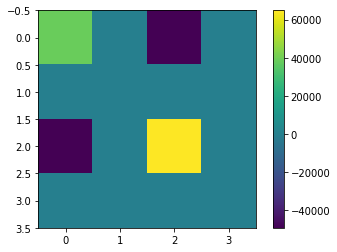

In [11]:
print(params_exp)
print(cov_expa)
plt.imshow(cov_expa)
plt.colorbar()

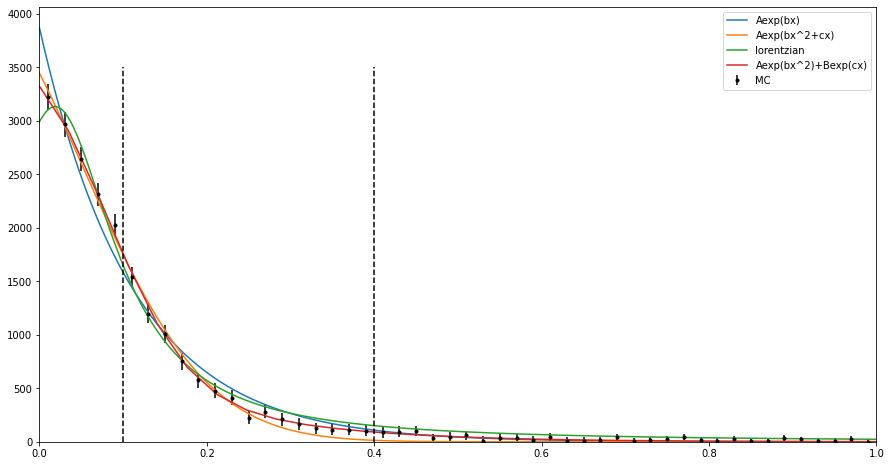

In [12]:
fig,ax = plt.subplots(1,1,figsize=[15,8])
ax.errorbar(df["binCentre"], df["Diff"], yerr=df["DiffErr"], label="MC", fmt=".", color="k")
#ax.plot(df["binCentre"], df["Diff"], "g.", label="DD")
ax.plot(np.linspace(0, 1.5, 1000), exp_distrib(np.linspace(0, 1.5, 1000), params_exp[0], params_exp[1]), label="Aexp(bx)")
#ax.plot(np.linspace(0, 3.5, 100), exp_quadratic(np.linspace(0, 3.5, 100), params_expq[0], params_expq[1]), label="Aexp(bx^2)")
ax.plot(np.linspace(0, 1.5, 1000), exp_quadratic_threeterm(np.linspace(0, 1.5, 1000), params_expqt[0], params_expqt[1], params_expqt[2]), label="Aexp(bx^2+cx)")
ax.plot(np.linspace(0, 1.5, 1000), lorentz(np.linspace(0, 1.5, 1000), params_lorentz[0], params_lorentz[1], params_lorentz[2]), label="lorentzian")
#ax.plot(np.linspace(0, 3.5, 100), rat(np.linspace(0, 3.5, 100), params_rat[0], params_rat[1]), label="rat")
ax.plot(np.linspace(0, 3.5, 100), exp_addition(np.linspace(0, 3.5, 100), params_expa[0], params_expa[1], params_expa[2], params_expa[3]), label="Aexp(bx^2)+Bexp(cx)")

ax.plot([0.4,0.4],[0,3500],"k--")
ax.plot([0.1,0.1],[0,3500],"k--")

ax.set_ylim(0, None)
ax.set_xlim(0, 1.0)
ax.legend()
fig.show()

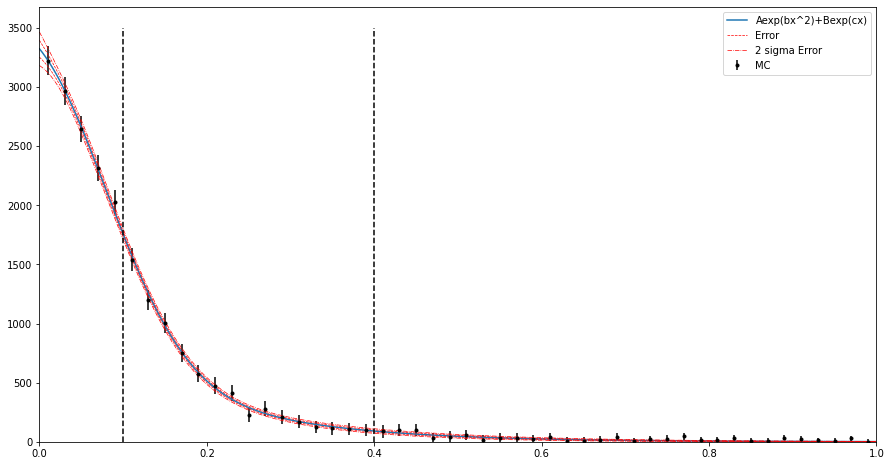

In [13]:
fig,ax = plt.subplots(1,1,figsize=[15,8])
ax.errorbar(df["binCentre"], df["Diff"], yerr=df["DiffErr"], label="MC", fmt=".", color="k")
ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3]), label="Aexp(bx^2)+Bexp(cx)")
ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])+exp_addition_err2(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--", label="Error", linewidth=0.7)
ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])-exp_addition_err2(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--", linewidth=0.7)
ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])+2*exp_addition_err2(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r-.", label="2 sigma Error", linewidth=0.7)
ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])-2*exp_addition_err2(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r-.", linewidth=0.7)
#ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])+exp_addition_quad_error(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "g--", label="quad Error")
# ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])-exp_addition_error(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--")
ax.plot([0.4,0.4],[0,3500],"k--")
ax.plot([0.1,0.1],[0,3500],"k--")

ax.set_ylim(0, None)
ax.set_xlim(0, 1.0)
ax.legend()
fig.show()

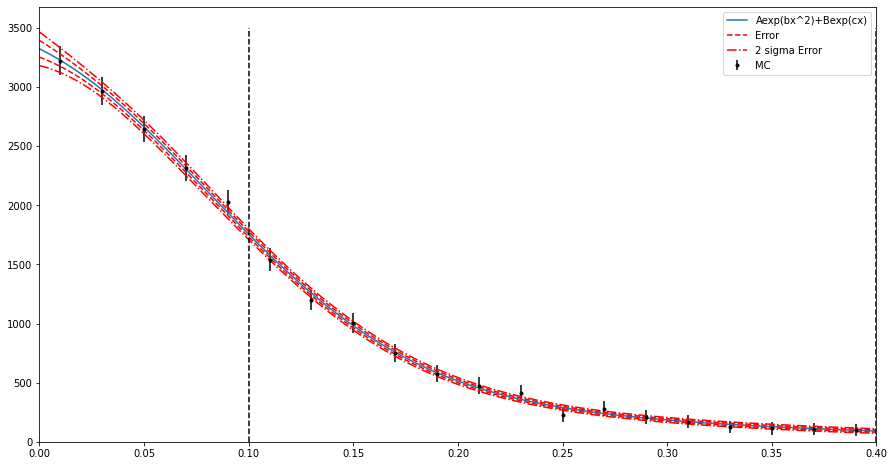

In [14]:
fig,ax = plt.subplots(1,1,figsize=[15,8])
ax.errorbar(df["binCentre"], df["Diff"], yerr=df["DiffErr"], label="MC", fmt=".", color="k")
ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3]), label="Aexp(bx^2)+Bexp(cx)")
ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])+exp_addition_err2(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--", label="Error")
ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])-exp_addition_err2(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--")
ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])+2*exp_addition_err2(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r-.", label="2 sigma Error")
ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])-2*exp_addition_err2(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r-.")
#ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])+exp_addition_quad_error(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "g--", label="quad Error")
# ax.plot(np.linspace(0, 3.5, 1000), exp_addition(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3])-exp_addition_error(np.linspace(0, 3.5, 1000), params_expa[0], params_expa[1], params_expa[2], params_expa[3], cov_expa), "r--")
ax.plot([0.4,0.4],[0,3500],"k--")
ax.plot([0.1,0.1],[0,3500],"k--")

ax.set_ylim(0, None)
ax.set_xlim(0, 0.4)
ax.legend()
fig.show()

In [15]:
INT01 = 1317

In [16]:
def get_int_04_to_b(func, b):
    return spi.quad(func, 0.4, b)[0]

def get_int_01(func):
    return spi.quad(func, 0.0, 0.1)[0]

def get_factor(func, b):
    #print("{:.3f} / {:.3f} * {:.3f} / {:.3f} ".format(INT_QCD_RCR, INT_MC_R, get_int_04_to_b(func, b), get_int_01(func)))
    return (INT_QCD_RCR*get_int_04_to_b(func, b))/(INT_MC_R * get_int_01(func))

In [17]:
spi.quad(exp_final, 0., 0.1)[0]
spi.quad(lorentz_final, 0., 0.1)[0]

261.43787034238477

In [18]:
for i in [1.0, 1.5, 2.0, 2.5, np.pi, 4.0, 5.0, 10.0, np.inf]:
    print("{:.3f}     {:.5f}".format(i, get_factor(expa_final, i)))

1.000     0.69194
1.500     0.70425
2.000     0.70468
2.500     0.70470
3.142     0.70470
4.000     0.70470
5.000     0.70470
10.000     0.70470
inf     0.70470


In [20]:
print(get_factor(expa_final_upper, np.pi), get_factor(expa_final_lower, np.pi), (get_factor(expa_final_upper, np.pi) - get_factor(expa_final_lower, np.pi))/2.)
print(get_factor(expa_final_upper2, np.pi), get_factor(expa_final_lower2, np.pi),  (get_factor(expa_final_upper2, np.pi) - get_factor(expa_final_lower2, np.pi))/2.)

0.8347738151481567 0.571254660833214 0.13175957715747139
0.9616123710395872 0.4343161625644037 0.2636481042375918
